# 기본 setting / 파일 불러오기

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.pyplot import figure as fig
import matplotlib.gridspec as gridspec
from iteration_utilities import flatten
import collections
import operator
import graphviz
from lightgbm import LGBMRegressor, plot_importance, plot_tree
# from xgboost import XGBRegressor, plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings(action= 'ignore')

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")
# 디렉토리에 넣어두고 사용
%run "./pickle_function/functions_variables.py"

식수예측 데이콘용 함수와 변수들을 저장한 파일 _ 210717 수정본


# 전처리

In [2]:
# 메뉴별 분류기 생성용 함수
# x에 모든 메뉴를 모은 리스트, name에는 각 리스트에 붙일 이름, 
# filter_list에는 필터 생성을 위한 단어들을 이중 리스트로 넣어줘야 함
# -> 이때 이중리스트의 마지막 항목은 건너뛰고 싶은 키워드들을 리스트로 넣어줌, 없으면 빈 리스트
# (ex. 밥의 경우 작은밥, 추가밥은 세지 말고 넘어가라는 뜻)
# 오류, 미분류가 있다면 프린트 될 것
# 필터를 거치는 메뉴들은 all_menu에서 삭제되도록 함
def filter_list(x, name, filter_list):
    jump = []
    rest = []
    overlap = []
    for i in range(1, len(filter_list)+1):
        globals()[f"{name}{i}"] = []
    for bab in x:
        check_num = 0
        for i, filters in enumerate(filter_list[:-1]):
            for sort in filters:
                if filters[0] == "(과일류)":
                    if sort == bab:
                        globals()[f"{name}{i+1}"].append(bab)
                        if bab in x:
                            check_num += 1
                            x[x.index(bab)] = bab + "(v)"
                elif sort in bab:
                    globals()[f"{name}{i+1}"].append(bab)
                    if bab in x:
                        check_num += 1
                        x[x.index(bab)] = bab + "(v)"
        for sort in filter_list[-1]:    
            if bab == sort:
                jump.append(bab)
                x[x.index(bab)] = bab + "(jump)"
                check_num += 1
#         if check_num ==0:
#             rest.append(bab)
        if check_num > 1:
            overlap.append(bab)
    print("미분류 항목: " , rest)
    print("중복된 항목: " , overlap)
    print("------------------------------------------------------------------------------------------------")
    return rest, overlap

def grid_menu(x):
    y = x[:4]
    return y

## 휴일, 연휴 전후 dummy

### 휴일 전후

In [3]:
stay = ['12-31','01-02','2016-02-06', '2016-02-11', '2017-01-26', '2017-01-31','2018-02-14', '2018-02-18', '2019-02-03',
        '2019-02-07', '2020-01-23', '2020-01-28', '2021-02-10', '2021-02-15', '02-28','02-29','03-02', '2016-04-12',
        '2016-04-14' '04-30','2020-04-14', '2020-04-16', '05-02', '05-04', '05-06', '2018-05-08', '2019-05-07', 
        '2016-05-13', '2016-05-15', '2017-05-02', '2017-05-04', '2017-05-08', '2017-05-10' '2018-05-21', '2018-05-23', 
        '2019-05-11', '2019-05-13', '2020-04-29', '2020-04-29', '2020-05-01','2021-05-18', '2021-05-20','06-05','06-07',
        '08-14', '08-16', '2016-09-13', '2016-09-17', '2017-10-02', '2017-10-07', '2018-06-12', '2018-06-14','2018-09-22',
        '2018-09-27', '2019-09-11', '2019-09-15', '2020-09-29', '2020-10-03', '2021-09-19', '2021-09-23', '10-02', 
        '10-04', '10-08', '10-10', '12-24','12-26', '2020-08-18']

temp = np.zeros(len(train))
count = 0
for date in stay:
    aa = np.array(train['일자'].str.contains(date))
    count = count + aa.sum()
    temp = temp + aa
print(temp.sum() == count, f"//train: True이면 중복 없이 총 {count}개의 휴일전후가 잘 만들어짐")
temp = list(temp)

eve = []
for day in train['요일']:
    if day == "금":
        eve.append(1)
    elif day == "월":
        eve.append(1)
    else:
        eve.append(0)

for i in range(len(eve)):
    if eve[i] == 0:
        pass
    else:
        temp[i] = 1
        
temp2 = np.zeros(len(test))
count2 = 0
for date in stay:
    aa = np.array(test['일자'].str.contains(date))
    count2 = count2 + aa.sum()
    temp2 = temp2 + aa
print(temp2.sum() == count2, f"//test: True이면 중복 없이 총 {count2}개의 휴일전후가 잘 만들어짐")
temp2 = list(temp2)

eve2 = []
for day in test['요일']:
    if day == "금":
        eve2.append(1)
    elif day == "월":
        eve2.append(1)
    else:
        eve2.append(0)

for i in range(len(eve2)):
    if eve2[i] == 0:
        pass
    else:
        temp2[i] = 1

print("train data:\n", f"{eve.count(1)}개의 월,금과 {count}개의 휴일 전후가 합쳐지면서 {temp.count(1)}개의 휴일전후 생성")
print("test data:\n", f"{eve2.count(1)}개의 월,금과 {count2}개의 휴일 전후가 합쳐지면서 {temp2.count(1)}개의 휴일전후 생성")
train.insert(1,"휴일전후", temp)
test.insert(1,"휴일전후", temp2)
train.head(3)

True //train: True이면 중복 없이 총 82개의 휴일전후가 잘 만들어짐
True //test: True이면 중복 없이 총 3개의 휴일전후가 잘 만들어짐
train data:
 482개의 월,금과 82개의 휴일 전후가 합쳐지면서 535개의 휴일전후 생성
test data:
 19개의 월,금과 3개의 휴일 전후가 합쳐지면서 21개의 휴일전후 생성


,일자,휴일전후,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,1.0,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,0.0,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,2016-02-03,0.0,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


### 연휴전후 (징검다리 포함 여부 선택)

In [4]:
date= list(train['일자'])
test_date= list(test['일자'])

h_before1 =[] #  연휴 이전
before1 = [
    '2016-02-05','2016-05-04','2016-06-03','2016-08-12','2016-09-13','2016-09-30','2017-01-26','2017-05-04',
           '2017-09-29','2017-12-22','2017-12-29','2018-02-14','2018-05-04','2018-09-21','2019-02-01','2019-02-28',
           '2019-05-03','2019-09-11','2020-01-23','2020-08-14','2020-09-29','2020-10-08','2020-12-24', '2020-12-31',
           '2016-02-11','2016-05-09','2016-06-07','2016-08-16','2016-09-19','2016-10-04','2017-01-31','2017-05-08',
           '2017-10-10','2017-12-26','2017-12-29', "2018-01-02",'2018-02-19','2018-05-08','2018-09-27','2019-02-07',
           '2019-03-04', '2019-05-07','2019-09-16','2020-01-28','2020-08-18','2020-10-05','2020-10-12','2020-12-28', 
           '2021-01-04',
          #징검다리휴일
          "2016-02-29", "2016-05-06", "2017-05-04", "2017-06-05","2017-08-14","2018-03-02","2018-05-21","2018-10-08",
          "2018-12-24","2018-12-31","2019-06-07","2019-08-16","2019-10-04","2020-05-01","2020-05-04"
          ]

for i in date:
    if i in before1:
        h_before1.append(1)
    else:
        h_before1.append(0) 

train.insert(3,'연휴전후', h_before1)

h_before2 = [] #  연휴 이전
before2 = ['2021-02-10','2021-02-26', '2021-02-15', '2021-03-02']

for i in test_date:
    if i in before2:
        h_before2.append(1)
    else:
        h_before2.append(0) 

test.insert(3,'연휴전후', h_before2)

train.head(2)

,일자,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,1.0,월,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016-02-02,0.0,화,0,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


## 일자 -> 년/월/일

In [5]:
# 훈련용 데이터
train['일자'] = train['일자'].astype(np.datetime64)

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day


train.drop(['일자'],axis = 1, inplace = True)

# 테스트 데이터
test['일자'] = test['일자'].astype(np.datetime64)

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day


test.drop(['일자'],axis = 1, inplace = True)

# column 정렬
train = train[train.columns.tolist()[-3:] + train.columns.tolist()[:-3]]
test = test[test.columns.tolist()[-3:] + test.columns.tolist()[:-3]]

train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016,2,1,1.0,월,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,2016,2,2,0.0,화,0,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0


In [6]:
# 휴일전후와 연휴전후 통합
for i in range(len(train)):
    if train["휴일전후"].iloc[i] ==1:
        if train["연휴전후"].iloc[i] ==1:
            train["연휴전후"].iloc[i] ==1
        elif train["연휴전후"].iloc[i] ==0:
            train["연휴전후"].iloc[i] ==1

for i in range(len(test)):
    if test["휴일전후"].iloc[i] ==1:
        if test["연휴전후"].iloc[i] ==1:
            test["연휴전후"].iloc[i] ==1
        elif test["연휴전후"].iloc[i] ==0:
            test["연휴전후"].iloc[i] ==1

## 요일 숫자로

In [7]:
train.replace({"년": [2016,2017,2018,2019,2020,2021] }, {"년": [0,0,0,0,10,10] }, inplace = True)
test.replace({"년": [2021] }, {"년": [10] }, inplace = True)
train.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,0,2,1,1.0,월,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,0,2,2,0.0,화,0,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,0,2,3,0.0,수,0,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [8]:
temp = [1,2,3,4,5,6,7,8,9,10,11,12]
train.replace({"월": temp }, {"월": [1,199,555,1,1,1,1,1,1,1,1,4]}, inplace = True)
test.replace({"월": temp }, {"월": [1,199,555,1,1,1,1,1,1,1,1,4]}, inplace = True)
train.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,0,199,1,1.0,월,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,0,199,2,0.0,화,0,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,0,199,3,0.0,수,0,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


In [9]:
train.replace({"요일": ["월","화","수","목","금"] }, {"요일": [3,2,1,2,0] }, inplace = True)
test.replace({"요일": ["월","화","수","목","금"] }, {"요일": [3,2,1,2,0] }, inplace = True)
train.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2,0,199,3,0.0,1,0,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0


## 재료에 따른 메뉴

In [10]:
temp = pd.concat([pd.DataFrame(train["중식메뉴"].apply(bracket_remover)), pd.DataFrame(train["석식메뉴"].apply(bracket_remover))], axis =1)
temp_test = pd.concat([pd.DataFrame(test["중식메뉴"].apply(bracket_remover)), pd.DataFrame(test["석식메뉴"].apply(bracket_remover))], axis =1)
temp = pd.concat([pd.DataFrame(temp["중식메뉴"].apply(star_remove)), pd.DataFrame(temp["석식메뉴"].apply(star_remove))], axis =1)
temp_test = pd.concat([pd.DataFrame(temp_test["중식메뉴"].apply(star_remove)), pd.DataFrame(temp_test["석식메뉴"].apply(star_remove))], axis =1)
temp = pd.concat([pd.DataFrame(temp["중식메뉴"].apply(grid_menu)), pd.DataFrame(temp["석식메뉴"].apply(grid_menu))], axis =1)
temp_test = pd.concat([pd.DataFrame(temp_test["중식메뉴"].apply(grid_menu)), pd.DataFrame(temp_test["석식메뉴"].apply(grid_menu))], axis =1)

q = ['중식','석식']
w = ['견과및두류','묵류','어패류','육류','채소류','뿌리류','해조류','면류','갑각류','계란류','떡류','유제품','만두류','간식류','과일류']

for i in q:
    for k in w:
        temp["{}({})".format(k,i)] = 0
    
for i in q:
    for k in w:
        temp_test["{}({})".format(k,i)] = 0

In [11]:
w = ['견과및두류','묵류','어패류','육류','채소류','뿌리류','해조류','면류','갑각류','계란류','떡류','유제품','만두류','간식류','과일류']

for qw in q:
    cnt = 0 
    for k in temp['{}메뉴'.format(qw)].tolist():
        for i in range(len(food_material)):
            for j in food_material[i]:
                if j in k:
                    temp['{}({})'.format(w[i],qw)].loc[cnt] += 1
        cnt += 1

for qw in q:
    cnt = 0 
    for k in temp_test['{}메뉴'.format(qw)].tolist():
        for i in range(len(food_material)):
            for j in food_material[i]:
                if j in k:
                    temp_test['{}({})'.format(w[i],qw)].loc[cnt] += 1
        cnt += 1


In [12]:
temp.drop(["중식메뉴", "석식메뉴"], axis = 1, inplace = True)
temp_test.drop(["중식메뉴", "석식메뉴"], axis = 1, inplace = True)

train = pd.concat([train.iloc[:,:-2] , temp ,train.iloc[:,-2:]], axis = 1)
test = pd.concat([test , temp_test], axis = 1)

## 메뉴 벡터화(train)

In [13]:
# 괄호 삭제
df_lunch = train["중식메뉴"].apply(bracket_remover)
df_dinner = train["석식메뉴"].apply(bracket_remover)

# * 뒤쪽 없애기
df_lunch.apply(star_remove)
df_dinner.apply(star_remove)

0               [쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]
1                     [콩나물밥, 어묵국, 유산슬, 아삭고추무침, 바나나, 포기김치]
2             [쌀밥/잡곡밥, 청국장찌개, 황태양념구이, 고기전, 새송이버섯볶음, 포기김치]
3                     [미니김밥, 우동, 멕시칸샐러드, 군고구마, 무피클, 포기김치]
4             [쌀밥/잡곡밥, 차돌박이찌개, 닭갈비, 감자소세지볶음, 콩나물무침, 포기김치]
                              ...                        
1200      [김치볶음밥, 미니쫄우동, 브로콜리깨소스무침, 계란후라이, 고들빼기무침, 겉절이김치]
1201        [흑미밥, 쇠고기무국, 삼치양념구이, 비엔나채소볶음, 숙주나물당근무침, 포기김치]
1202    [흑미밥, 수제비국, 수제맛쵸킹탕수육, 유부채소겨자냉채, 참나물무침, 갓김치/겉절이김치]
1203                   [흑미밥, 열무된장국, 장어강정, 깻잎쌈, 오이선, 포기김치]
1204          [할라피뇨멸치주먹밥, 잔치국수, 수제고기육전, 쑥갓나물, 양파초절임, 깍두기]
Name: 석식메뉴, Length: 1205, dtype: object

In [14]:
# 오타 수동 처리
df_lunch[1003] = ['카레라이스', '미소시루', '감자만두', '애기새송이버섯볶음',  '골뱅이야채무침', '포기김치']
df_lunch[1039] = ['쌀밥/잡곡밥', '왕갈비탕', '해물전', '쫄면야채무침', '꼬시래기무초무침', '황도샐러드',
                  '포도주스', '석박지']
df_lunch[1041] = ['쌀밥/잡곡밥', '아욱수제비국', '해물섞어찜', '크레미계란말이',
                  '통오이고추무침', '치커리유자샐러드','알로에주스', '깍두기']
df_lunch[1161] = ['쌀밥/흑미밥/찰현미밥', '순두부찌개', '요거닭', 
                  '비엔나채소볶음', '오이쑥갓생채', '포기김치', '라면땅', '양상추샐러드']
df_lunch[1142] = ['쌀밥/곤드레밥/찰현미밥', '된장찌개', '돼지고추장불고기', 
                  '버섯잡채', '삼색물만두무침', '겉절이김치', '견과류샐러드']
df_dinner[956] = ['카레라이스', '맑은국', '생선까스', '멕시칸샐러드',  '오복지무침', '포기김치']
df_dinner[1048] = ['계란김밥', '모듬어묵탕', '고구마맛탕', '꽃맛살샐러드', '배', '음료', '깍두기']
df_dinner[1027] = ['작은밥', '백종원의고추짜장', '맑은국', '칠리베이비크랩', '시금치흑임자샐러드', 
                   '단무지', '포기김치']
df_dinner[1040] = ['쌀밥/잡곡밥', '우삼겹부대찌개', '조기구이', '수제어묵볶음', '섬초무침', '배추겉절이']
df_dinner[1045] = ['쌀밥/잡곡밥', '삼선짬뽕국', '춘장돈육볶음', '어묵잡채볶음', '참나물무침', '배추겉절이']
df_dinner[1150] = ["유부초밥", "쌀밥", "온모밀국수", "돈까스김치나베", "양배추샐러드", "오이지무침", "무생채"]

# 대분류 위해 메뉴명 변경
sorts = [soup_sort, kimchi_sort, salad_sort, fry_sort, pancake_sort, zzim_sort, mandu_sort,
        stirfry_sort, boiled_sort, goo2_sort, mix_sort, chicken_sort, dduk_sort,
        drink_sort, milk_sort, zzul_im_sort, bread_sort, dduk_sort]
for sort in sorts:
    df_lunch.apply(sort)
    df_dinner.apply(sort)
    df_lunch.apply(sort)
    df_dinner.apply(sort)

In [15]:
# 모든 메뉴에 대해 분류 기준 형성하기
all_menu = all_menu_list(df_lunch, df_dinner)
all_menu_copy = all_menu.copy()
filter_list(all_menu, "rice", rice_filter)
filter_list(all_menu, "soup", soup_filter)
filter_list(all_menu, "vege", vege_filter)
filter_list(all_menu, "dessert", dessert_filter)

미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------


([], [])

In [16]:
# 분류할 사전 생성
rice_dict = {"쌀밥류": list(set(rice1)),
            "덮밥국밥류": list(set(rice2)),
            "비빔밥볶음밥류": list(set(rice3)),
            "김초밥류": list(set(rice4)),
            "국수류": list(set(rice5)),
            "죽류": list(set(rice6))}
soup_dict = {"국탕류": list(set(soup1)),
            "찌개류": list(set(soup2)),
            "스프류": list(set(soup3))}
vege_dict = {"김치류": list(set(vege1)),
            "샐러드류": list(set(vege2)),
            "튀김류": list(set(vege3)),
            "전류": list(set(vege4)),
            "찜류": list(set(vege5)),
            "볶음류": list(set(vege6)),
            "조림류": list(set(vege7)),
            "구이류": list(set(vege8)),
            "무침류": list(set(vege9)),
            "장아찌류": list(set(vege10))
            }
dessert_dict = {"음료": list(set(dessert1)),
                "유제품": list(set(dessert2)),
                "빵과자류": list(set(dessert3)),
                "과일류": list(set(dessert4))
}

* 중식

In [17]:
# 중복실행하지 않도록 주의!
rice1_df = to_dataframe(df_lunch.copy().apply(class_major, dic = rice_dict), train)
rice1_df.columns = ["인기메뉴(중식)", "덮밥국밥류(중식)", "비빔밥볶음밥류(중식)", "김초밥류(중식)", "국수류(중식)",
                   "죽류(중식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , rice1_df ,train.iloc[:,-2:]], axis = 1)
train.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,간식류(석식),과일류(석식),인기메뉴(중식),덮밥국밥류(중식),비빔밥볶음밥류(중식),김초밥류(중식),국수류(중식),죽류(중식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,867.0,560.0
2,0,199,3,0.0,1,0,2601,56,180,111,...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1017.0,573.0


* 석식

In [18]:
rice2_df = to_dataframe(df_dinner.copy().apply(class_major, dic = rice_dict), train)
rice2_df.columns = ["인기메뉴(석식)", "덮밥국밥류(석식)", "비빔밥볶음밥류(석식)", "김초밥류(석식)", "국수류(석식)", 
                    "죽류(석식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , rice2_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,국수류(중식),죽류(중식),인기메뉴(석식),덮밥국밥류(석식),비빔밥볶음밥류(석식),김초밥류(석식),국수류(석식),죽류(석식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,867.0,560.0


* 중식

In [19]:
# 국탕지찌개류
soup1_df = to_dataframe(df_lunch.copy().apply(class_major, dic = soup_dict), train)
soup1_df.columns = ["국탕류(중식)", "찌개류(중식)", "스프류(중식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , soup1_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,덮밥국밥류(석식),비빔밥볶음밥류(석식),김초밥류(석식),국수류(석식),죽류(석식),국탕류(중식),찌개류(중식),스프류(중식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,867.0,560.0


* 석식

In [20]:
# 국탕지찌개류
soup2_df = to_dataframe(df_dinner.copy().apply(class_major, dic = soup_dict), train)
soup2_df.columns = ["국탕류(석식)", "찌개류(석식)", "스프류(석식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , soup2_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,국수류(석식),죽류(석식),국탕류(중식),찌개류(중식),스프류(중식),국탕류(석식),찌개류(석식),스프류(석식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,867.0,560.0


* 중식

In [21]:
# 반찬류
vege1_df = to_dataframe(df_lunch.copy().apply(class_major, dic = vege_dict), train)
vege1_df.columns = ["김치류(중식)", "샐러드류(중식)", "튀김류(중식)", "전류(중식)", "찜류(중식)",
                   "볶음류(중식)", "조림류(중식)", "구이류(중식)", "무침류(중식)", "장아찌류(중식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , vege1_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,튀김류(중식),전류(중식),찜류(중식),볶음류(중식),조림류(중식),구이류(중식),무침류(중식),장아찌류(중식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,867.0,560.0


* 석식

In [22]:
# 반찬류
vege2_df = to_dataframe(df_dinner.copy().apply(class_major, dic = vege_dict), train)
vege2_df.columns = ["김치류(석식)", "샐러드류(석식)", "튀김류(석식)", "전류(석식)", "찜류(석식)",
                   "볶음류(석식)", "조림류(석식)", "구이류(석식)", "무침류(석식)", "장아찌류(석식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , vege2_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,튀김류(석식),전류(석식),찜류(석식),볶음류(석식),조림류(석식),구이류(석식),무침류(석식),장아찌류(석식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,867.0,560.0


* 중식

In [23]:
# 디저트류
dessert1_df = to_dataframe(df_lunch.copy().apply(class_major, dic = dessert_dict), train)
dessert1_df.columns = ["음료(중식)", "유제품(중식)", "빵과자류(중식)", "과일류(중식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , dessert1_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,조림류(석식),구이류(석식),무침류(석식),장아찌류(석식),음료(중식),유제품(중식),빵과자류(중식),과일류(중식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,867.0,560.0


* 석식

In [24]:
# 디저트류
dessert2_df = to_dataframe(df_dinner.copy().apply(class_major, dic = dessert_dict), train)
dessert2_df.columns = ["음료(석식)", "유제품(석식)", "빵과자류(석식)", "과일류(석식)"]

# column 정렬
train = pd.concat([train.iloc[:,:-2] , dessert2_df ,train.iloc[:,-2:]], axis = 1)
train.head(2)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,음료(중식),유제품(중식),빵과자류(중식),과일류(중식),음료(석식),유제품(석식),빵과자류(석식),과일류(석식),중식계,석식계
0,0,199,1,1.0,3,0,2601,50,150,238,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1039.0,331.0
1,0,199,2,0.0,2,0,2601,50,173,319,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,867.0,560.0


## 메뉴 벡터화(test)

In [25]:
# 괄호 제거
df_lunch_test = test["중식메뉴"].apply(bracket_remover)
df_dinner_test = test["석식메뉴"].apply(bracket_remover)

# * 뒤쪽 없애기
df_lunch_test.apply(star_remove)
df_dinner_test.apply(star_remove)

# 대분류 위해 메뉴명 변경
# sorts는 train 할 때 정의
for sort in sorts:
    df_lunch_test.apply(sort)
    df_dinner_test.apply(sort)
    df_lunch_test.apply(sort)
    df_dinner_test.apply(sort)

In [26]:
# 모든 메뉴에 대해 분류 기준 형성하기
all_menu_test = all_menu_list(df_lunch_test, df_dinner_test)
all_menu_sum = all_menu_copy + all_menu_test
all_menu_sum_copy = all_menu_sum.copy()
filter_list(all_menu_sum, "rice", rice_filter)
filter_list(all_menu_sum, "soup", soup_filter)
filter_list(all_menu_sum, "vege", vege_filter)
filter_list(all_menu_sum, "dessert", dessert_filter)

미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  ['브로콜리숙회', '채소스틱', '유부채소겨자냉채', '타워함박스테이크', '쌈채소', '브로콜리숙회(v)', '채소스틱(v)', '타워함박스테이크(v)', '유부채소겨자냉채(v)', '쌈채소(v)']
------------------------------------------------------------------------------------------------
미분류 항목:  []
중복된 항목:  []
------------------------------------------------------------------------------------------------


([], [])

In [27]:
# 분류할 사전 생성
rice_dict_test = {"쌀밥류": list(set(rice1)),
            "덮밥국밥류": list(set(rice2)),
            "비빔밥볶음밥류": list(set(rice3)),
            "김초밥류": list(set(rice4)),
            "국수류": list(set(rice5)),
             "죽류": list(set(rice6))}
soup_dict_test = {"국탕류": list(set(soup1)),
            "찌개류": list(set(soup2)),
            "스프류": list(set(soup3))}
vege_dict_test = {"김치류": list(set(vege1)),
            "샐러드류": list(set(vege2)),
            "튀김류": list(set(vege3)),
            "전류": list(set(vege4)),
            "찜류": list(set(vege5)),
            "볶음류": list(set(vege6)),
            "조림류": list(set(vege7)),
            "구이류": list(set(vege8)),
            "무침류": list(set(vege9)),
            "장아찌류": list(set(vege10))
            }
dessert_dict_test = {"음료": list(set(dessert1)),
                "유제품": list(set(dessert2)),
                "빵과자류": list(set(dessert3)),
                 "과일류": list(set(dessert4))
}

* 중식

In [28]:
# 중복실행하지 않도록 주의!
rice1_df_test = to_dataframe(df_lunch_test.copy().apply(class_major, dic = rice_dict_test), test)
rice1_df_test.columns = ["인기메뉴(중식)", "덮밥국밥류(중식)", "비빔밥볶음밥류(중식)", "김초밥류(중식)", "국수류(중식)",
                        "죽류(중식)"]

# column 정렬
test = pd.concat([test , rice1_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,유제품(석식),만두류(석식),간식류(석식),과일류(석식),인기메뉴(중식),덮밥국밥류(중식),비빔밥볶음밥류(중식),김초밥류(중식),국수류(중식),죽류(중식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0


* 석식

In [29]:
# 중복실행하지 않도록 주의!
rice2_df_test = to_dataframe(df_dinner_test.copy().apply(class_major, dic = rice_dict_test), test)
rice2_df_test.columns = ["인기메뉴(석식)", "덮밥국밥류(석식)", "비빔밥볶음밥류(석식)", "김초밥류(석식)", "국수류(석식)",
                        "죽류(석식)"]

# column 정렬
test = pd.concat([test , rice2_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,비빔밥볶음밥류(중식),김초밥류(중식),국수류(중식),죽류(중식),인기메뉴(석식),덮밥국밥류(석식),비빔밥볶음밥류(석식),김초밥류(석식),국수류(석식),죽류(석식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


* 중식

In [30]:
# 국탕지찌개류
soup1_df_test = to_dataframe(df_lunch_test.copy().apply(class_major, dic = soup_dict_test), test)
soup1_df_test.columns = ["국탕류(중식)", "찌개류(중식)", '스프류(중식)']

# column 정렬
test = pd.concat([test , soup1_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,죽류(중식),인기메뉴(석식),덮밥국밥류(석식),비빔밥볶음밥류(석식),김초밥류(석식),국수류(석식),죽류(석식),국탕류(중식),찌개류(중식),스프류(중식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


* 석식

In [31]:
# 국탕지찌개류
soup2_df_test = to_dataframe(df_dinner_test.copy().apply(class_major, dic = soup_dict_test), test)
soup2_df_test.columns = ["국탕류(석식)", "찌개류(석식)", '스프류(석식)']

# column 정렬
test = pd.concat([test , soup2_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,비빔밥볶음밥류(석식),김초밥류(석식),국수류(석식),죽류(석식),국탕류(중식),찌개류(중식),스프류(중식),국탕류(석식),찌개류(석식),스프류(석식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


* 중식

In [32]:
# 반찬류
vege1_df_test = to_dataframe(df_lunch_test.copy().apply(class_major, dic = vege_dict_test), test)
vege1_df_test.columns = ["김치류(중식)", "샐러드류(중식)", "튀김류(중식)", "전류(중식)", "찜류(중식)",
                         "볶음류(중식)", "조림류(중식)", "구이류(중식)", "무침류(중식)", "장아찌류(중식)"]

# column 정렬
test = pd.concat([test , vege1_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,김치류(중식),샐러드류(중식),튀김류(중식),전류(중식),찜류(중식),볶음류(중식),조림류(중식),구이류(중식),무침류(중식),장아찌류(중식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


* 석식

In [33]:
# 반찬류
vege2_df_test = to_dataframe(df_dinner_test.copy().apply(class_major, dic = vege_dict_test), test)
vege2_df_test.columns = ["김치류(석식)", "샐러드류(석식)", "튀김류(석식)", "전류(석식)", "찜류(석식)",
                         "볶음류(석식)", "조림류(석식)", "구이류(석식)", "무침류(석식)", "장아찌류(석식)"]

# column 정렬
test = pd.concat([test , vege2_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,김치류(석식),샐러드류(석식),튀김류(석식),전류(석식),찜류(석식),볶음류(석식),조림류(석식),구이류(석식),무침류(석식),장아찌류(석식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


* 중식

In [34]:
# 디저트류
dessert1_df_test = to_dataframe(df_lunch_test.copy().apply(class_major, dic = dessert_dict_test), test)
dessert1_df_test.columns = ["음료(중식)", "유제품(중식)", "빵과자류(중식)", "과일류(중식)"]

# column 정렬
test = pd.concat([test , dessert1_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,찜류(석식),볶음류(석식),조림류(석식),구이류(석식),무침류(석식),장아찌류(석식),음료(중식),유제품(중식),빵과자류(중식),과일류(중식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


* 석식

In [35]:
# 디저트류
dessert2_df_test = to_dataframe(df_dinner_test.copy().apply(class_major, dic = dessert_dict_test), test)
dessert2_df_test.columns = ["음료(석식)", "유제품(석식)", "빵과자류(석식)", "과일류(석식)"]

# column 정렬
test = pd.concat([test , dessert2_df_test], axis = 1)
test.head(3)

,년,월,일,휴일전후,요일,연휴전후,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,...,무침류(석식),장아찌류(석식),음료(중식),유제품(중식),빵과자류(중식),과일류(중식),음료(석식),유제품(석식),빵과자류(석식),과일류(석식)
0,10,1,27,0.0,1,0,2983,88,182,5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,1,28,0.0,2,0,2983,104,212,409,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10,1,29,1.0,0,0,2983,270,249,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 삭제할 컬럼 삭제

In [36]:
# 메뉴 삭제
drops = ["조식메뉴", "중식메뉴", "석식메뉴","일"]
drop_menu = ["과일","유제품"]
for x in train.columns:
    for y in drop_menu:
        if y in x:
            drops.append(x)

In [37]:
train.drop(drops, axis = 1, inplace = True)
test.drop(drops, axis = 1, inplace = True)

## 카테고리화

In [38]:
to_category = []
for x in train.columns:
    if (x.endswith("수")) or (x.endswith("계")):
        train[x] = train[x].astype('float64')
    else:
        to_category.append(x)
for x in to_category:
    train[x] = train[x].astype('category')

In [39]:
to_category = []  
for x in test.columns:
    if (x.endswith("수")) or (x.endswith("계")):
        test[x] = test[x].astype('float64')
    else:
        to_category.append(x)
for x in to_category:
    test[x] = test[x].astype('category')

## 인원컬럼 조정

* 본사정원수 - 재택근무수, 재택근무인원은 뒤에서 drop

In [40]:
train["본사정원수"] = (train["본사정원수"]  - train["현본사소속재택근무자수"])
test["본사정원수"] = (test["본사정원수"] - test["현본사소속재택근무자수"])

In [41]:
bins = [0,10,2000]
labels = [1,2]
train["야근"] = pd.cut(train["본사시간외근무명령서승인건수"],bins, right = False, labels = labels)
test["야근"] = pd.cut(test["본사시간외근무명령서승인건수"],bins, right = False, labels = labels)
train = pd.concat([train.iloc[:,:-3] , train["야근"] ,train.iloc[:,-3:-1]], axis = 1)

# 모델링

## 데이터프레임 나누기

In [42]:
temp = train.drop(train.index[train["석식계"]==0])
# 중식 예측시 석식 0 drop하지 않도록 주의
X1 = temp.drop(["중식계"], axis = 1)
y1 = temp["중식계"]
X2 = temp.iloc[:, :-2]
y2 = temp["석식계"]

In [43]:
X100 = test.iloc[:, :].copy()
X200 = test.iloc[:, :].copy()

## 중식, 석식 예측에 별도 컬럼 사용하기

In [44]:
drop_lunch = ["현본사소속재택근무자수"]
for x in X1.columns:
    if ("(석식)" in x) or ("(조식)" in x) or ("휴일전후" in x) or ("시간외" in x) or ("야근" in x):
        drop_lunch.append(x)
drop_lunch
drop_dinner = ["현본사소속재택근무자수", "김치류(석식)", "음료(석식)", "해조류(석식)", "묵류(석식)", "스프류(석식)"]
for x in X1.columns:
    if ("(중식)" in x) or ("(조식)" in x) or ("휴일전후" in x):
        drop_dinner.append(x)
drop_lunch, drop_dinner

# 중식 메뉴는 중식만, 석식 메뉴는 석식만 예측하도록
X1.drop(drop_lunch, axis = 1, inplace = True)
X2.drop(drop_dinner, axis = 1, inplace = True)

# X4.drop(drop_dinner, axis = 1, inplace = True)

X100 = X100.drop(drop_lunch, axis = 1)
X200 = X200.drop(drop_dinner, axis = 1)

In [45]:
for x in [X1, X100, X2, X200]:
    temp = x.columns
    temps = []
    for i, y in enumerate(temp):
        y += f'{i}'
        temps.append(y)
    x.columns = temps

# for x in [X1, X100, X4, X200]:
#     temp = x.columns
#     temps = []
#     for i, y in enumerate(temp):
#         y += f'{i}'
#         temps.append(y)
#     x.columns = temps

## 최종 컬럼

In [46]:
X1.columns, X100.columns, len(X1)

(Index(['년0', '월1', '요일2', '연휴전후3', '본사정원수4', '본사휴가자수5', '본사출장자수6',
        '견과및두류(중식)7', '묵류(중식)8', '어패류(중식)9', '육류(중식)10', '채소류(중식)11',
        '뿌리류(중식)12', '해조류(중식)13', '면류(중식)14', '갑각류(중식)15', '계란류(중식)16',
        '떡류(중식)17', '만두류(중식)18', '간식류(중식)19', '인기메뉴(중식)20', '덮밥국밥류(중식)21',
        '비빔밥볶음밥류(중식)22', '김초밥류(중식)23', '국수류(중식)24', '죽류(중식)25', '국탕류(중식)26',
        '찌개류(중식)27', '스프류(중식)28', '김치류(중식)29', '샐러드류(중식)30', '튀김류(중식)31',
        '전류(중식)32', '찜류(중식)33', '볶음류(중식)34', '조림류(중식)35', '구이류(중식)36',
        '무침류(중식)37', '장아찌류(중식)38', '음료(중식)39', '빵과자류(중식)40', '석식계41'],
       dtype='object'),
 Index(['년0', '월1', '요일2', '연휴전후3', '본사정원수4', '본사휴가자수5', '본사출장자수6',
        '견과및두류(중식)7', '묵류(중식)8', '어패류(중식)9', '육류(중식)10', '채소류(중식)11',
        '뿌리류(중식)12', '해조류(중식)13', '면류(중식)14', '갑각류(중식)15', '계란류(중식)16',
        '떡류(중식)17', '만두류(중식)18', '간식류(중식)19', '인기메뉴(중식)20', '덮밥국밥류(중식)21',
        '비빔밥볶음밥류(중식)22', '김초밥류(중식)23', '국수류(중식)24', '죽류(중식)25', '국탕류(중식)26',
        '찌개류(중식)27', '스프류(중식)28', '김

In [47]:
X2.columns, X200.columns, len(X2)

(Index(['년0', '월1', '요일2', '연휴전후3', '본사정원수4', '본사휴가자수5', '본사출장자수6',
        '본사시간외근무명령서승인건수7', '견과및두류(석식)8', '어패류(석식)9', '육류(석식)10', '채소류(석식)11',
        '뿌리류(석식)12', '면류(석식)13', '갑각류(석식)14', '계란류(석식)15', '떡류(석식)16',
        '만두류(석식)17', '간식류(석식)18', '인기메뉴(석식)19', '덮밥국밥류(석식)20', '비빔밥볶음밥류(석식)21',
        '김초밥류(석식)22', '국수류(석식)23', '죽류(석식)24', '국탕류(석식)25', '찌개류(석식)26',
        '샐러드류(석식)27', '튀김류(석식)28', '전류(석식)29', '찜류(석식)30', '볶음류(석식)31',
        '조림류(석식)32', '구이류(석식)33', '무침류(석식)34', '장아찌류(석식)35', '빵과자류(석식)36',
        '야근37'],
       dtype='object'),
 Index(['년0', '월1', '요일2', '연휴전후3', '본사정원수4', '본사휴가자수5', '본사출장자수6',
        '본사시간외근무명령서승인건수7', '견과및두류(석식)8', '어패류(석식)9', '육류(석식)10', '채소류(석식)11',
        '뿌리류(석식)12', '면류(석식)13', '갑각류(석식)14', '계란류(석식)15', '떡류(석식)16',
        '만두류(석식)17', '간식류(석식)18', '인기메뉴(석식)19', '덮밥국밥류(석식)20', '비빔밥볶음밥류(석식)21',
        '김초밥류(석식)22', '국수류(석식)23', '죽류(석식)24', '국탕류(석식)25', '찌개류(석식)26',
        '샐러드류(석식)27', '튀김류(석식)28', '전류(석식)29', '찜류(석식)30', '볶음류(석식)31',


## 석식 모델링

cv: 7


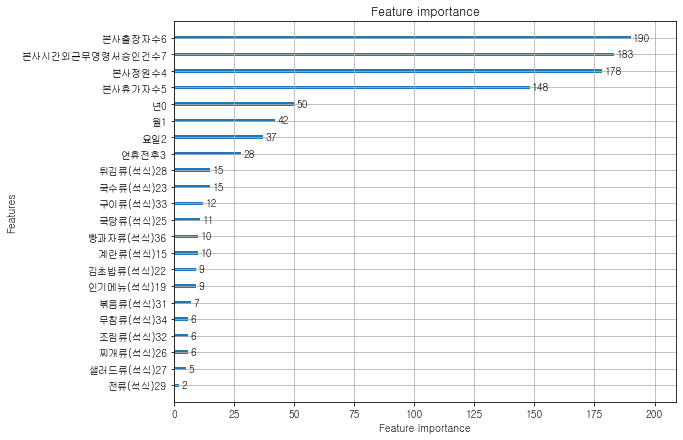

best_score:  -45.3722884854072 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 12} 
 std:  6    2.295314
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------
cv: 12


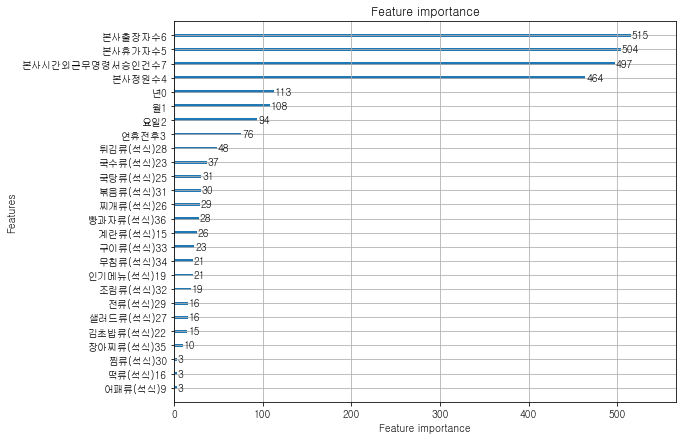

best_score:  -45.71339911583789 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 250, 'num_leaves': 12} 
 std:  3    3.262815
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------
cv: 13


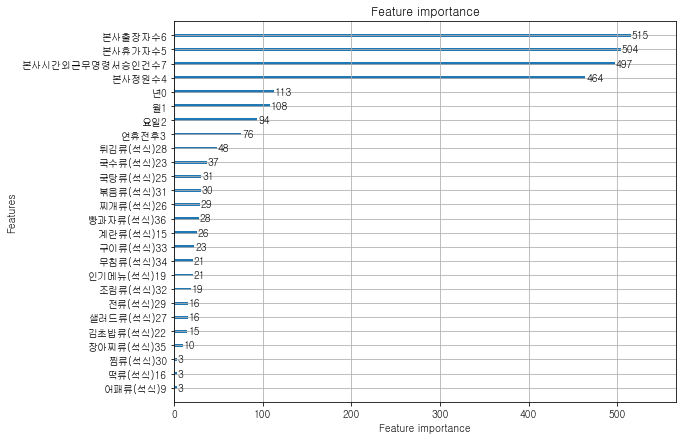

best_score:  -45.73997246532815 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 250, 'num_leaves': 12} 
 std:  3    2.995721
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------


In [48]:
params = {'n_estimators':[150, 250],
    'max_depth' : [9], # 나무의 깊이(층)
    'learning_rate' : [0.05, 0.1],
    "colsample_bytree" : [1],
    'num_leaves' : [12, 18, 20],
    "boosting_type" : ['gbdt'],
#     "min_child_samples" : [5, 10, 15]
         } 
lgbm_model = LGBMRegressor(metric = "regression_l1")
test_size2 = 0.05; random_state2 =23; 
early_stop_round2 = 50; cv_list2 = [7,12,13]
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=test_size2, random_state=random_state2 , shuffle = True)
fit_params={"early_stopping_rounds":early_stop_round2, 
            "eval_set" : [[X_test, y_test]]}
best_models2 = []
params2 = []
scores2 = []
for x in cv_list2:
    grid_model = GridSearchCV(lgbm_model, param_grid=params, cv = x, scoring = "neg_mean_absolute_error")

    # param_grid의 하이퍼파라미터들을 순차적으로 학습
 
    grid_model.fit(X_train, y_train, **fit_params, verbose=False)

#     GridSearchCV 결과 추출하여 DataFrame으로 변환
    scores_df = pd.DataFrame(grid_model.cv_results_)
    std_test_score2 = scores_df[scores_df["rank_test_score"] ==1]["std_test_score"]
    best_model = grid_model.best_estimator_
    params2.append(grid_model.best_params_)
    scores2.append(grid_model.best_score_)
    print("cv:", x )
    fig, ax = plt.subplots(figsize = (9,7))
    plot_importance(best_model, ax=ax)
    plt.show()
    print("best_score: ",grid_model.best_score_ ,"\n","best-params: ", grid_model.best_params_, "\n","std: ", std_test_score2)
    print("--------------------------------------------------------------------------------------------------------")
    scores_df
    best_models2.append(best_model)

In [49]:
top_score2 = sorted(scores2, reverse = True)[0]
top_score_param2 = params2[scores2.index(top_score2)]
best_cv2 = cv_list2[scores2.index(top_score2)]
print("top-score:",top_score2)
print("top-score-params:", top_score_param2)
print(f"cv: {best_cv2}, test_size: {test_size2}, random_state: {random_state2}, early_stop_round: {early_stop_round2}")

top-score: -45.3722884854072
top-score-params: {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 12}
cv: 7, test_size: 0.05, random_state: 23, early_stop_round: 50


In [50]:
submit_list2 = []
for model in best_models2:
    pred_submit = model.predict(X200)
    submit_list2.append(pred_submit)
submit_list2

[array([425.77146563, 448.50121211, 263.89773321, 530.58885092,
        494.74842133, 496.52266671, 504.59604224, 439.11218877,
        671.09374981, 548.09739995, 289.75502922, 713.88206492,
        695.7901291 , 469.31827641, 534.63426187, 416.35419649,
        701.26391666, 652.13223327, 426.17336149, 518.49938513,
        306.60658531, 695.16947839, 478.6721113 , 566.30672962,
        415.7557259 , 698.77206809, 688.52177344, 440.4178623 ,
        568.76946851, 342.37037532, 712.81488311, 637.08718536,
        469.63863368, 541.43884353, 309.27036375, 670.5100803 ,
        649.7772918 , 434.47552224, 467.28473765, 308.87563915,
        680.03465541, 646.79218169, 419.21060857, 410.65419683,
        259.62603468, 592.60312493, 540.19008803, 433.50936631,
        400.50775881, 279.57471058]),
 array([423.29898336, 441.25434363, 245.55121901, 531.20505132,
        481.40413219, 507.15845001, 507.34734605, 449.60598371,
        650.96079788, 534.93749869, 277.60415861, 726.92015022,
  

In [51]:
X100["석식계"] = submit_list2[scores2.index(top_score2)]

## 중식 모델링

cv: 7


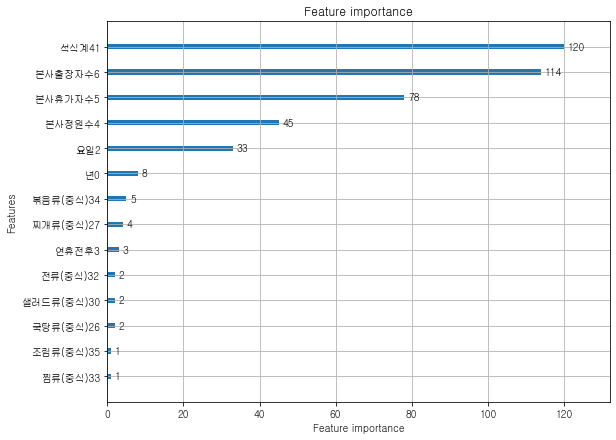

best_score:  -67.15138740784344 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 20} 
 std:  8     4.369692
11    4.369692
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------
cv: 12


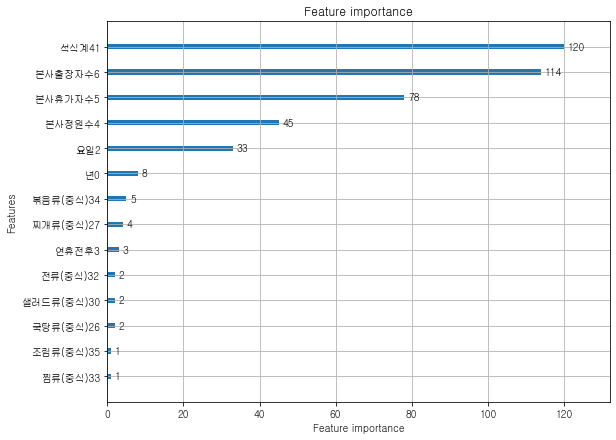

best_score:  -68.01091885681366 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 20} 
 std:  8     6.180191
11    6.180191
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------
cv: 13


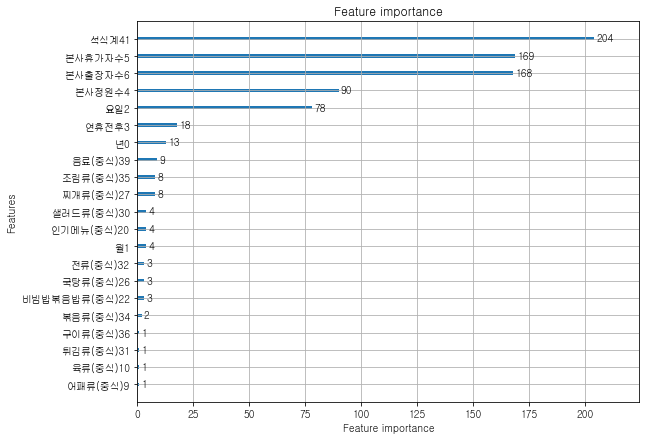

best_score:  -68.16945460518721 
 best-params:  {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 12} 
 std:  0    6.48756
Name: std_test_score, dtype: float64
--------------------------------------------------------------------------------------------------------


In [52]:
params = {'n_estimators':[150, 250],
    'max_depth' : [9], # 나무의 깊이(층)
    'learning_rate' : [0.05, 0.1],
    'num_leaves' : [12, 18, 20],
    "colsample_bytree" : [1],
    "boosting_type" : ['gbdt'],
#     "min_child_samples" : [5, 10, 15]
         } 
lgbm_model = LGBMRegressor(metric = "regression_l1")
test_size1 = 0.05; random_state1 =23; 
early_stop_round1 = 50; cv_list1 = [7,12,13]
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=test_size1, random_state=random_state1, shuffle = True)
fit_params={"early_stopping_rounds":early_stop_round1, 
            "eval_set" : [[X_test, y_test]]}
best_models1 = []
params1 = []
scores1 = []
for x in cv_list1:
    grid_model = GridSearchCV(lgbm_model, param_grid=params, cv = x, scoring = "neg_mean_absolute_error")

    # param_grid의 하이퍼파라미터들을 순차적으로 학습
 
    grid_model.fit(X_train, y_train, **fit_params, verbose=False)

#     GridSearchCV 결과 추출하여 DataFrame으로 변환
    scores_df = pd.DataFrame(grid_model.cv_results_)
    std_test_score1 = scores_df[scores_df["rank_test_score"] ==1]["std_test_score"]
    best_model = grid_model.best_estimator_
    params1.append(grid_model.best_params_)
    scores1.append(grid_model.best_score_)
    print("cv:", x )
    fig, ax = plt.subplots(figsize = (9,7))
    plot_importance(best_model, ax=ax)
    plt.show()
    print("best_score: ",grid_model.best_score_ ,"\n","best-params: ", grid_model.best_params_, "\n","std: ", std_test_score1)
    print("--------------------------------------------------------------------------------------------------------")
    scores_df
    best_models1.append(best_model)

In [53]:
top_score1 = sorted(scores1, reverse = True)[0]
top_score_param1 = params1[scores1.index(top_score1)]
best_cv1 = cv_list1[scores1.index(top_score1)]
print("top-score:",top_score1)
print("top-score-params:", top_score_param1)
print(f"cv: {best_cv1}, test_size: {test_size1}, random_state: {random_state1}, early_stop_round: {early_stop_round1}")

top-score: -67.15138740784344
top-score-params: {'boosting_type': 'gbdt', 'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 150, 'num_leaves': 20}
cv: 7, test_size: 0.05, random_state: 23, early_stop_round: 50


In [54]:
submit_list = []
for model in best_models1:
    pred_submit = model.predict(X100)
    submit_list.append(pred_submit)
submit_list

[array([1011.60614398,  915.05527455,  625.91672373, 1157.02854486,
         953.22078605, 1017.31799622,  937.86747971,  703.16132043,
        1273.70267148,  996.52090098,  737.474758  , 1273.83559384,
        1106.25565877, 1029.33406169,  888.74043435,  707.01534375,
        1255.55129889, 1098.49692656,  933.54954688,  868.11413369,
         627.22238445, 1148.72372758, 1007.15535041,  930.13787898,
         685.35084754, 1261.32496933, 1111.099804  , 1027.81637112,
         969.96977494,  704.09516029, 1258.82044605, 1032.85596471,
        1007.62442029,  945.06117442,  646.84740064, 1256.45698783,
        1093.65278133,  928.36287547,  838.02606913,  632.92803318,
        1255.55129889, 1118.18481078,  957.56032986,  892.45990589,
         606.19773109, 1171.31787544, 1002.89824488,  952.33385786,
         900.86583679,  615.15202344]),
 array([1011.60614398,  915.05527455,  625.91672373, 1157.02854486,
         953.22078605, 1017.31799622,  937.86747971,  703.16132043,
        

# 학습 최고 점수 결과 취합 및 저장

In [55]:
submission["중식계"] = submit_list[scores1.index(top_score1)]*1.075
submission["석식계"] = submit_list2[scores2.index(top_score2)]*1.02

In [56]:
submission.describe()

,중식계,석식계
count,50.000000,50.000000
mean,1033.630129,516.241802
std,213.185745,137.979356
min,651.662561,264.818555
25%,938.766012,429.267839
50%,1036.047431,505.548255
75%,1187.139674,657.253251
max,1369.373263,728.159706


array([[<AxesSubplot:title={'center':'중식계'}>,
        <AxesSubplot:title={'center':'석식계'}>]], dtype=object)

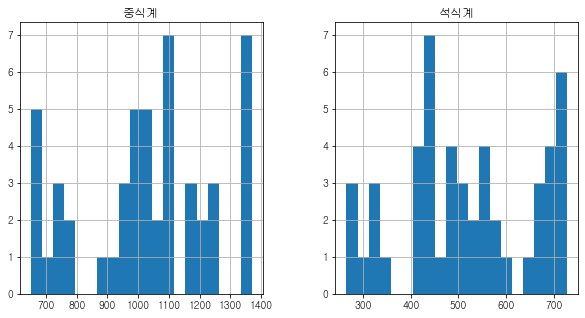

In [57]:
submission.hist(bins = 20, figsize = (10,5))

## 저장 및 기록

* 제출 파일 저장

In [58]:
submission.to_csv("./submission/sub_1.csv", index = False)